<a href="https://colab.research.google.com/github/rajkstats/corise-applied-ml/blob/main/wk2_PART_1_Simple_2D_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2. Part 1: Classification with two-dimensional data




In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Instructions

1. We provide starter code and data to give your work a common starting point and structure. You must keep function signatures unchanged to support later usage and to ensure your project is graded successfully.
2. Read through the document and starting code before beginning your work. Understand the overall structure and goals of the project to ensure your implementation is efficient.  
3. Do the following 2-D exercise prior to the next notebook to ensure that you are familiar with basic metrics and problem formulation for classification tasks. Once you're comfortable with the concepts and code in this notebook, move on to the notebook that contains part two for more complex modeling work.

# Preliminaries of Classification Modeling

Much like regression (which you saw last week), classification falls under the paradigm of supervised learning models. Recall the components of a supervised model:
* Dataset $\mathcal{D}$ with input/output pairs $(x,y) \in \mathcal{D}$
* Function approximation model $f_\theta(x)→y$
* Loss(objective) function $\mathcal{L}_{\mathcal{D}}(f_\theta )$
* Training procedure to find $\underset{\theta \in \Theta}{\operatorname{argmin}} \mathcal{L}_\mathcal{D}(f_\theta )$

### ML problem formulation: Classification vs regression
Recall our high-level framework for ML problem formulation, which includes formulating the function $f(x)→y$ that we plan to approximate. In this notation, $x = [x_1, x_2, \ldots]$ is a set of independent variables (i.e., inputs) where as $y$ is a response variable.

In the previous week, we looked at regression problems, where the response variable $y$ is a real valued number. This week, we study a second major type of machine learning: classification. Now the response variable $y$ is one of $K$ different values, and the goal for the function $f$ to place $x$ into the right bin. For example, $x$ could represent natural language with $y$ indicating positive or negative sentiment (two bins). Alternatively, $x$ could be a company's financial data with $y$ representing if the stock will rise or fall (two bins). 

### Starting with linear classification

Linear classification algorithms model data by dividing the input space into two classes using a linear equation. More generally, classification problems are concerned with $K$ different classes, but for simplicity, we will start with $K=2$. Somewhat confusingly, this model is called *logistic regression*, despite being a classification model. Let's write out the components of logistic regression:

**Function approximation model: (2-class) [Logistic regression](https://www.analyticsvidhya.com/blog/2020/10/demystification-of-logistic-regression/)**

$f_\theta(x) = \sigma(\theta_1 x_1 + \theta_2 x_2 + ...)$

$\hat{y} = \begin{cases}
1 & \text{ if } f_\theta(x) \geq 0.5 \\ 0 & \text{ if } f_\theta(x) < 0.5
\end{cases}$

Notice that the approximation is almost the same as the approximation for linear regression: The model chooses a linear form so that there is a $\theta_i$ for each input variable $x_i$. The difference is the additional function $\sigma$ that wraps around the linear form. This is called the *logistic function*, $\sigma(x) = \frac{1}{1+e^{-x}}$.

We can visualize the logistic function:

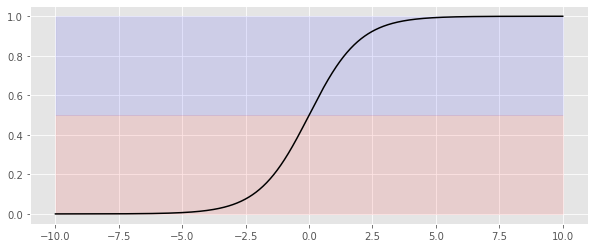

In [2]:
x = np.linspace(-10, 10, 1000)
y = 1. / (1. + np.exp(-x))

plt.figure(figsize=(10, 4))
plt.plot(x, y, color='black')
plt.fill_between(x, 0.5, 1, alpha=0.1, color='b')
plt.fill_between(x, 0, 0.5, alpha=0.1, color='r')
plt.show()

One important feature of the logistic function is that it maps numbers from negative infinity to infinity on the x-axis to the bounded interval $[0, 1]$ on the y-axis. We can see why this might be useful for classification, as $\theta_1 x_1 + \theta_2 x_2 + \ldots \in \mathbb{R}$ represents any real-valued number, but $\sigma(\theta_1 x_1 + \theta_2 x_2 + \ldots)$ represents the predicted probability of the output $\hat{y}$ being class 1. 

In the figure, the shaded areas show that the output of the logistic function is split into two classes at 0.5. If $f_\theta(x) \geq 0.5$, we predict class 1 (blue) but if $f_\theta(x) < 0.5$, we predict class 0 (red).

**Loss function: Binary cross entropy**

$\mathcal{L}_\mathcal{D}(\theta) = -\sum_{i \in \mathcal{D}} \left (y^{(i)} \log f_\theta(x^{(i)}) + (1 - y^{(i)}) \log (1 - f_\theta(x^{(i)})) \right)$

where $y^{(i)}$ is the $i$-th element in the dataset $\mathcal{D}$. Looking at the form of this loss function, if $y^{(i)} = 0$ then the first term of the sum is $0$ and we are rewarded more as $f_\theta(x^{(i)}) \rightarrow 1$; if $y^{(i)} = 1$ then the second term of the sum is $0$ and we are rewarded more as $f_\theta(x^{(i)}) \rightarrow 0$.

**Training procedure**

As we did in Week 1, we will not go into too much detail on the training process and instead rely on fast optimization that scales to large tasks. 

# Building a first classification model

We want to be able to visualize model predictions, so we will restrict this example to a two-dimensional plane (i.e., two input features $x_1$ and $x_2$). This allows us to visualize the line that determines the classification between two classes. 

To showcase this, we'll make a toy dataset by sampling random values for the input features $x_1, x_2$ and define the output $y$ to be $y = \sigma(w_1 x_1 + w_2 x_2 + \epsilon)$ where $w_1$ and $w_2$ are weight parameters (that we will train models to learn) and $\epsilon$ is a term to inject random noise into this toy dataset (such that it is not completely trivial for a model to learn). 

### Creating a toy dataset

We start by picking some true parameters of the model (see `w_true` below). Using these parameters, we can generate target variables $y$ given the randomly chosen inputs $x_1, x_2$. For real world datasets, we do not know the true `w_true` but in toy datasets that we generate from scratch, we know the underlying parameters!

In [3]:
# parameters of toy dataset
n_examples = 500

def sigmoid(x): 
  return 1. / (1. + np.exp(-x))

# uniformly sample inputs x.
rs = np.random.RandomState(42)

def make_toy_linear(n_examples, rs):
  w_true = np.array([[-0.5, 0.5]])
  dataset_X = rs.rand(n_examples,2)
  noise = 0.2 * rs.rand(n_examples,1)
  dataset_y = (w_true @ dataset_X.T).T + noise
  dataset_y = sigmoid(dataset_y).ravel()
  dataset_y = (dataset_y >= 0.5).astype(int)  # Q: why do need to round?
  return dataset_X, dataset_y 

dataset_X, dataset_y = make_toy_linear(n_examples, rs)

We can plot each example in the dataset as a point in 2-D space (using $x_1$ and $x_2$ as the two axes). Then, we can color each point blue if it has class 1 or red if it has class 0. We purposefully inject noise into this process to make the toy dataset more representative of real world data, where there is naturally noise in the data collection and annotation. 

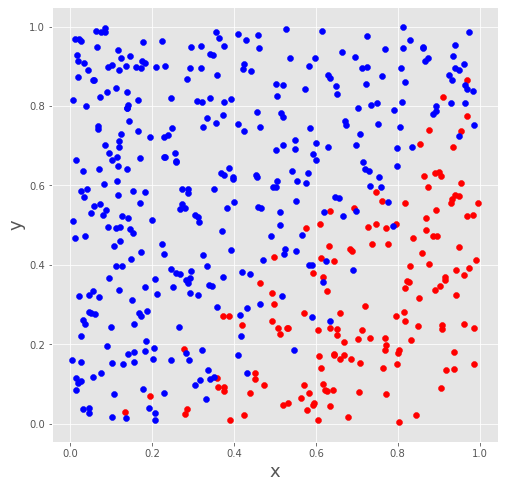

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(dataset_X[dataset_y == 0, 0], dataset_X[dataset_y == 0, 1], color='r')
plt.scatter(dataset_X[dataset_y == 1, 0], dataset_X[dataset_y == 1, 1], color='b')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

Mentally, it should be easy for you to draw a "best fit line" that divides the blue and red points. Let's see if we can do that with various models by exploring the unique characteristics of different model families.

### Creating a nonlinear toy dataset

Before we move forward with training the models, however, let's first make a second, slightly more difficult dataset: one that requires some nonlinearity to solve.

In [5]:
# parameters of toy dataset
n_examples = 500

def sigmoid(x): 
  return 1. / (1. + np.exp(-x))

rs = np.random.RandomState(42)

def make_toy_circle(n_examples, rs):
  # uniformly sample inputs x.)
  dataset_X_circ = 2 * rs.rand(n_examples,2) - 1
  noise_circ = 0.3 * rs.rand(n_examples,1)
  radius = dataset_X_circ[:, 0]**2 + dataset_X_circ[:, 1]**2
  dataset_y_circ = radius  + noise_circ.ravel()
  dataset_y_circ = (dataset_y_circ > 0.6).astype(int)
  return dataset_X_circ, dataset_y_circ

dataset_X_circ, dataset_y_circ = make_toy_circle(n_examples, rs)

As you can see, we roughly drew a circle (with some noise added in). Everything inside the circle is class 1 and everything outside of it is class 0.

Unlike the dataset above, this dataset does not have a `w_true`. Why? Because the previous dataset was generated using a logistic regression model! Here, we used a different generation process: sampling points from a unit square and then classifying points using a circular region.

**Question**:
How well do you think logistic regression will perform on both datasets? Why?

**Logistic Regresssion will perform well on linear toy  dataset as compared to non-linear toy dataset since logistic regressions assumes a linear relationship between data points and in non-linear dataset, data points are not linearly correlated which would cause high bias.**

We'll find out if your intuitions are correct below through experiments! 

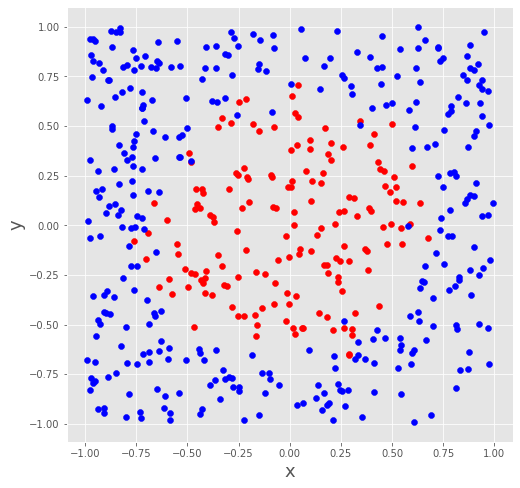

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(dataset_X_circ[dataset_y_circ == 0, 0], 
            dataset_X_circ[dataset_y_circ == 0, 1], color='r')
plt.scatter(dataset_X_circ[dataset_y_circ == 1, 0], 
            dataset_X_circ[dataset_y_circ == 1, 1], color='b')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

# Training / fitting the model

First, let's train a linear model using the scikit-learn package. We recommend looking at the [documentation](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) for more details. When calling `fit()`, scikit-learn will use the training dataset to find the model weights which best optimize the loss function (in this case, binary cross entropy). We will do so for both toy datasets and visualize the results.

Let's start by training a model on each dataset:

In [8]:
from sklearn.linear_model import LogisticRegression

## fit basic linear model with scikit
regr_2d = LogisticRegression()
# this command trains (fits) the model using the dataset passed in
regr_2d.fit(dataset_X, dataset_y)

# train another model for the nonlinear dataset
regr_circ = LogisticRegression()
regr_circ.fit(dataset_X_circ, dataset_y_circ)

LogisticRegression()

### Generating predictions

After training the models, we're ready to visualize our results.

Starting with the model trained on the linear dataset, we will overlay a plot of the model's decision function, i.e. how the model splits positive and negative classes (shown as a black line below), on top of the dataset plot (red and blue points from above):

In [9]:
def get_contour(model, min_x=0, max_x=1, min_y=0, max_y=1,
                step_x=0.01, step_y=0.01):
  """
  Generic script to plot decision boundaries captured 
  by a model. 
  """
  # define a mesh grid and pass it through the model
  xx, yy = np.meshgrid(np.arange(min_x, max_x, step_x),
                        np.arange(min_y, max_y, step_y))
  grid = np.c_[xx.ravel(), yy.ravel()]
  # make predictions based on the model
  preds = model.predict(grid)
  z = np.rint(preds).astype(np.int)
  z = z.reshape(xx.shape)
  return z, xx, yy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


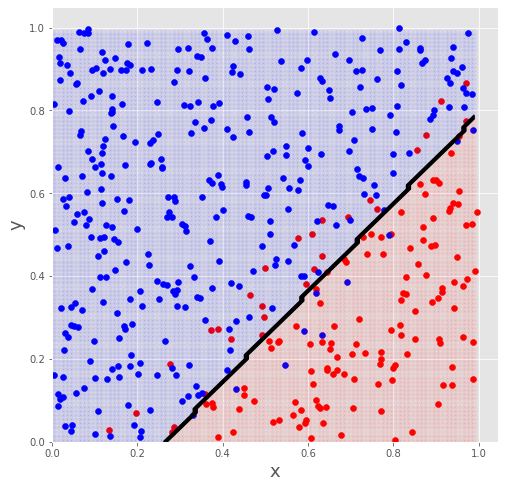

In [10]:
# sklearn provides prediction function as a standard interface for models
z, xx, yy = get_contour(regr_2d, min_x=0, max_x=1, min_y=0, max_y=1)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_X[dataset_y == 0, 0], dataset_X[dataset_y == 0, 1], color='r')
plt.scatter(dataset_X[dataset_y == 1, 0], dataset_X[dataset_y == 1, 1], color='b')
plt.contour(xx, yy, z, colors='k')
plt.scatter(xx[z == 0], yy[z == 0], color='r', alpha=0.05)
plt.scatter(xx[z == 1], yy[z == 1], color='b', alpha=0.05)
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

The model does a good job of splitting the two classes apart. In particular, in the noisy region where there are both blue and red points, the line sits roughly in the middle, minimizing the error as best it can.

Now, let's use the same approach to visualize the results of the model trained on the circular dataset:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


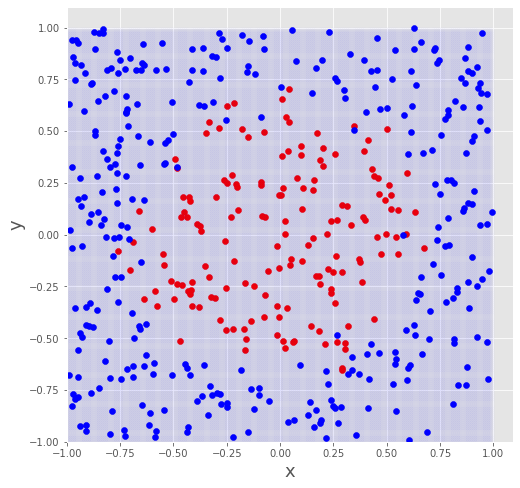

In [11]:
# sklearn provides prediction function as a standard interface for models
z, xx, yy = get_contour(regr_circ, min_x=-1, max_x=1, min_y=-1, max_y=1)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_X_circ[dataset_y_circ == 0, 0], 
            dataset_X_circ[dataset_y_circ == 0, 1], color='r')
plt.scatter(dataset_X_circ[dataset_y_circ == 1, 0], 
            dataset_X_circ[dataset_y_circ == 1, 1], color='b')
plt.scatter(xx[z == 0], yy[z == 0], color='r', alpha=0.01)
plt.scatter(xx[z == 1], yy[z == 1], color='b', alpha=0.01)
plt.contour(xx, yy, z, colors='k')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

Interestingly, there is **no** contour visualized? Let's take a look at what the model's predictions actually are.

In [12]:
from collections import Counter
Counter(regr_circ.predict(dataset_X_circ))

Counter({1: 500})

Looks like the model only predicts positive values and accepts the error of being wrong on the negative points.

**Question:**
Why do you think the model does this? 

HINT: count the number of positive and negative examples in our circle dataset.

In [14]:
# 1's are positive examples and 0's are negative examples
print(Counter(dataset_y_circ))

Counter({1: 338, 0: 162})



*   *Positive Samples* : 338
*   *Negative Samples* : 162



In [21]:
# Ratio of Negative and positive examples
positive_examples = Counter(dataset_y_circ)[1]
negative_examples = Counter(dataset_y_circ)[0]
total_examples = Counter(dataset_y_circ)[0]+ Counter(dataset_y_circ)[1]
print("positive examples", positive_examples)
print("negative examples", negative_examples)
print("total examples", total_examples)

positive examples 338
negative examples 162
total examples 500


**Ratio of Negative and positive examples is skewed towards postive examples which is 0.67 more than the negative samples**

In [24]:
print("Ratio:",  positive_examples/total_examples)

Ratio: 0.676


Did these results for these models match your intuition? Why or why not? Was anything unexpected?

**Yes, Results were based on my intuition which was based on the assumption of linear relationship between data points in logistic regression model**

# Improving results with nonlinear classification models

To summarize our results so far, the linear model performed fairly well on the linear toy dataset, which is to be expected since the dataset is generated with a linear function. However, the model struggled on the circular dataset, which is also expected as it is impossible to draw a circle with a straight line.

Using a linear model on the circle dataset leads to underfitting, as no possible choice of weights could perform well on the classification task. In other words, the variation of the dataset exceeds the variation that a linear model can capture.

Given the qualitative performance of the logistic regression model, can we do better with more popular models that have potentially nonlinear decision boundaries? 

*Advanced:* If you want to build intuition about particular ML algorithms in sklearn, you can review the [documentation](https://scikit-learn.org/stable/supervised_learning.html) or use this [plot](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

For a mathematical long-form introduction to different classifier models and their underlying mathematical principles, see the CS229 lecture videos.



Now that we're ready to explore new models, we'll first use the `DecisionTreeClassifier` in the scikit-learn package to train decision tree models on our linear and circular datasets:

In [25]:
from sklearn.tree import DecisionTreeClassifier

# fit the decision tree on the linear dataset
regr_2d_dt = DecisionTreeClassifier(max_leaf_nodes=30)
regr_2d_dt.fit(dataset_X, dataset_y)

# fit the decision tree on the circle dataset
regr_circ_dt = DecisionTreeClassifier(max_leaf_nodes=30)
regr_circ_dt.fit(dataset_X_circ, dataset_y_circ)

DecisionTreeClassifier(max_leaf_nodes=30)

On a high level, a decision tree learns a decision function through a tree of decision nodes, where each node defines an `if statement` (e.g. `if x1 > 0.5, then ...`). In other words, decision trees consist of step-like functions that partition the input space into different regions, with each region having an associated predicted class.

The hyperparameter `max_leaf_nodes` bounds the number of if statements that the decision tree can capture. Increasing this value creates a more expressive model but increases the risk of overfitting.

As we did with the linear model, let's now visualize the results of our decision trees for each dataset!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


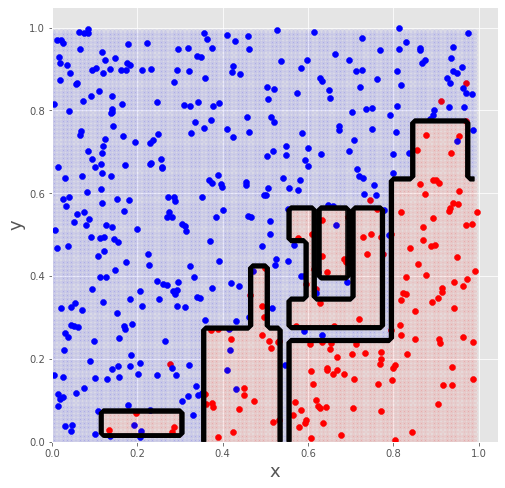

In [26]:
# Toy linear dataset

z, xx, yy = get_contour(regr_2d_dt, min_x=0, max_x=1, min_y=0, max_y=1)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_X[dataset_y == 0, 0], dataset_X[dataset_y == 0, 1], color='r')
plt.scatter(dataset_X[dataset_y == 1, 0], dataset_X[dataset_y == 1, 1], color='b')
plt.scatter(xx[z == 0], yy[z == 0], color='r', alpha=0.05)
plt.scatter(xx[z == 1], yy[z == 1], color='b', alpha=0.05)
plt.contour(xx, yy, z, colors='k')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


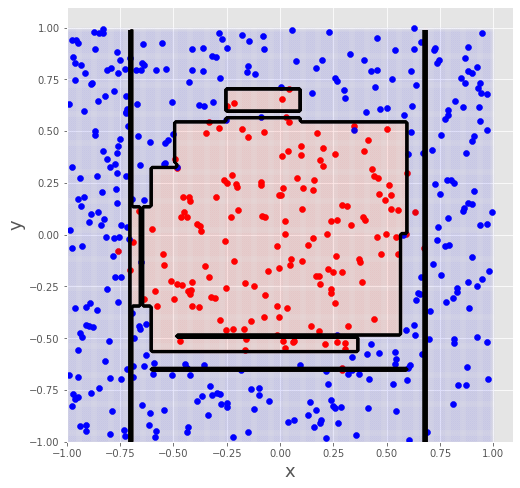

In [27]:
z, xx, yy = get_contour(regr_circ_dt, min_x=-1, max_x=1, min_y=-1, max_y=1)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_X_circ[dataset_y_circ == 0, 0], 
            dataset_X_circ[dataset_y_circ == 0, 1], color='r')
plt.scatter(dataset_X_circ[dataset_y_circ == 1, 0], 
            dataset_X_circ[dataset_y_circ == 1, 1], color='b')
plt.scatter(xx[z == 0], yy[z == 0], color='r', alpha=0.01)
plt.scatter(xx[z == 1], yy[z == 1], color='b', alpha=0.01)
plt.contour(xx, yy, z, colors='k')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

**Question:** 

It looks like all the decision functions from the decision tree are axis-aligned, e.g. parallel to either the x or y axis. Why do you think this is? 

HINT: You can print out the decision function as a tree of if statements using the following:
```
from sklearn.tree import export_text
print(export_text(regr_2d_dt, feature_names=['x1', 'x2']))
```

**Decision Function for Linear**

In [29]:
from sklearn.tree import export_text
print(export_text(regr_2d_dt, feature_names=['x1', 'x2']))

|--- x1 <= 0.56
|   |--- x2 <= 0.27
|   |   |--- x1 <= 0.35
|   |   |   |--- x2 <= 0.07
|   |   |   |   |--- x1 <= 0.12
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- x1 >  0.12
|   |   |   |   |   |--- x2 <= 0.02
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- x2 >  0.02
|   |   |   |   |   |   |--- x1 <= 0.31
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- x1 >  0.31
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- x2 >  0.07
|   |   |   |   |--- class: 1
|   |   |--- x1 >  0.35
|   |   |   |--- x1 <= 0.54
|   |   |   |   |--- x2 <= 0.12
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- x2 >  0.12
|   |   |   |   |   |--- class: 0
|   |   |   |--- x1 >  0.54
|   |   |   |   |--- class: 1
|   |--- x2 >  0.27
|   |   |--- x1 <= 0.46
|   |   |   |--- class: 1
|   |   |--- x1 >  0.46
|   |   |   |--- x2 <= 0.42
|   |   |   |   |--- x1 <= 0.51
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- x1 >  0.51
|   |   |   |   |   

**Decision Function for Non-Linear**

In [30]:
from sklearn.tree import export_text
print(export_text(regr_circ_dt, feature_names=['x1', 'x2']))

|--- x1 <= -0.60
|   |--- x1 <= -0.70
|   |   |--- class: 1
|   |--- x1 >  -0.70
|   |   |--- x1 <= -0.70
|   |   |   |--- class: 0
|   |   |--- x1 >  -0.70
|   |   |   |--- x2 <= -0.34
|   |   |   |   |--- class: 1
|   |   |   |--- x2 >  -0.34
|   |   |   |   |--- x2 <= 0.14
|   |   |   |   |   |--- x1 <= -0.66
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- x1 >  -0.66
|   |   |   |   |   |   |--- x1 <= -0.64
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- x1 >  -0.64
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- x2 >  0.14
|   |   |   |   |   |--- class: 1
|--- x1 >  -0.60
|   |--- x1 <= 0.60
|   |   |--- x2 <= -0.56
|   |   |   |--- x2 <= -0.65
|   |   |   |   |--- class: 1
|   |   |   |--- x2 >  -0.65
|   |   |   |   |--- x2 <= -0.65
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- x2 >  -0.65
|   |   |   |   |   |--- class: 1
|   |   |--- x2 >  -0.56
|   |   |   |--- x2 <= 0.55
|   |   |   |   |--- x1 <= -0.48
|   |   |

The first thing we notice is that the learned decision boundary for the linear dataset seems overly complex -- while it definitely seems to split the blue and red points apart very well, it doesn't match our intuitive understanding of the correct decision function. In other words, it is overfitting to the noise, rather than the signal from the dataset.

On the other dataset, it looks like the model was more faithfully able to draw a funny-looking circle, although perhaps it is still overfitting.

**Task:**

Try changing the `max_leaf_nodes` hyperparameter: make it smaller and make it bigger. Can you find a "perfect" value? Describe your experience below.

===== (Write your answer here) =====

# Classification error metrics

As visually pleasing as decision functions are, we would also like to have a quantitative analysis. For classification, there is a rich library of metrics that we can use to measure performance on our held-out dev set. Here, we'll introduce four such metrics for two-way classification.

Let's first define some notation. A true positive (TP) is defined as a positive example that the model correctly classifies as positive. Simlarly, a true negative (TN) is a negative example that is correctly predicted as negative. A false positive (FP), on the other hand, is a negative example that the model incorrectly classifies as positive. False negatives (FN) are analogously defined.

If we put the four values TN, TP, FP, and FN into a two-by-two matrix, we get a *confusion matrix*. ML practitioners widely use the confusion matrix as a way to track and diagnose model performance.

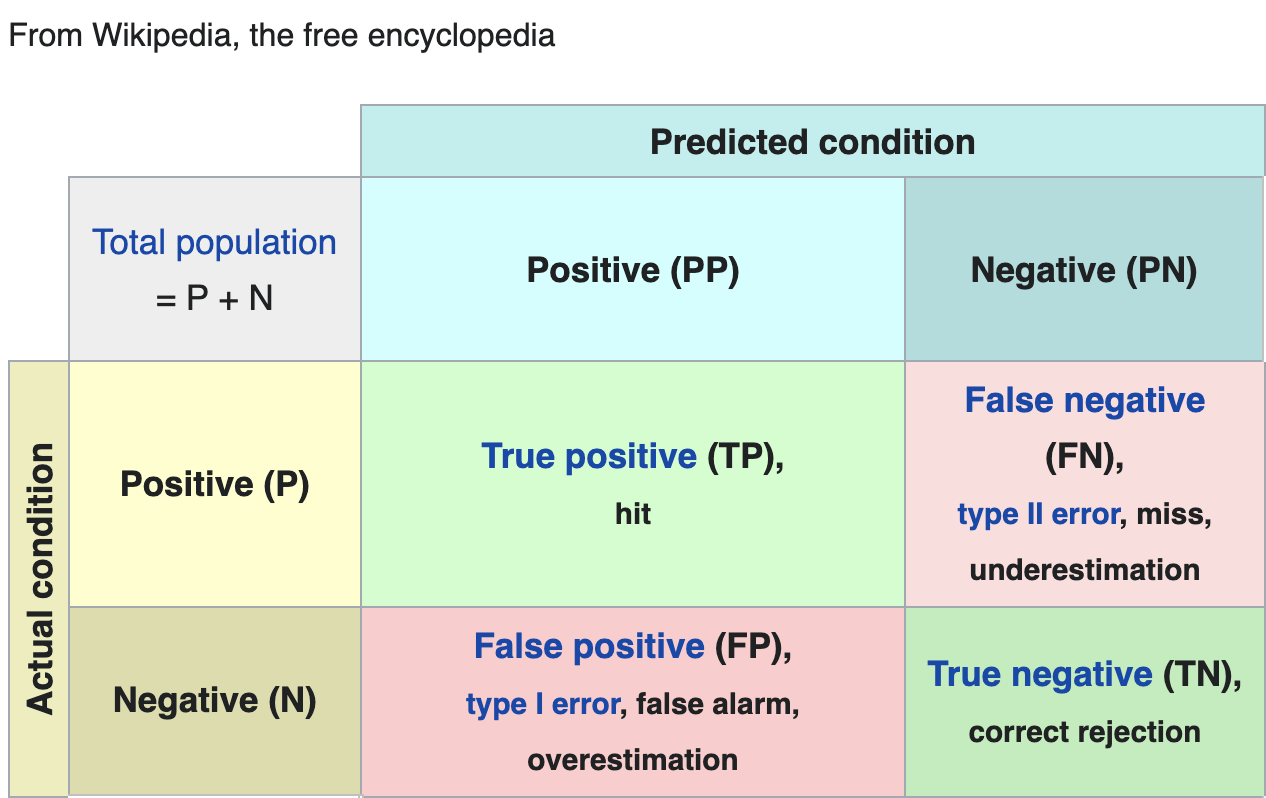

In [32]:
# Let's use scikit-learn to print the confusion matrix
from sklearn.metrics import confusion_matrix

# get predictions and predicted probabilities
pred_y_2d = regr_2d.predict(dataset_X)

print('Linear model on Linear dataset')
print('[[TN FP]]\n [FN TP]]')
print(confusion_matrix(dataset_y, pred_y_2d))

# Looks like we do pretty well! Not many FPs and FNs, with mostly TPs and TNs.

Linear model on Linear dataset
[[TN FP]]
 [FN TP]]
[[121  29]
 [ 10 340]]


With this in our vocabulary, let's begin! Below we will focus on a more mathematical definition of these metrics. Once we implement them, we will revisit and provide a more high-level interpretation.

The simplest metric is average accuracy: Given the predictions of the model, the model is accurate if the prediction matches the true label and inaccurate otherwise. We compute average accuracy over a dev-set, $\frac{1}{n}\sum_{i=1}^n (y^{(i)} == \hat{y}^{(i)})$ where $y^{(i)}$ represents the label of the $i$-th example of the dataset. Another way to define accuracy is $\frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$. 

**Precision, Recall & F1**

The next metric is precision, which is the number of correct positive predictions divided by all times the model predicted positive values, $\frac{\text{TP}}{\text{TP} + \text{FP}}$. Along with precision, we are usually interested in recall, which is the number of correct positive predictions divided by the number of true positive examples, $\frac{\text{TP}}{\text{TP} + \text{FN}}$.

It is important to consider precision and recall together, because a model can have trivially high precision or recall if only one factor is considered. The F1 score acts as a summary statistic that is a combination of precision and recall. It is defined as  $\text{F1} = 2 * \frac{\text{precision} * \text{recall}}{\text{precision} + \text{recall}}$.

For all of these metrics, a higher score is better!

### Task: Using the formulas given above, implement the accuracy, precision, recall, and F1 metrics. Each function should return the relevant metric.

In [38]:
# TASK: Implement accuracy, precision, recall, and F1 as functions.

def accuracy_score(y, y_hat):
  
  tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
 
  score = ((tn + tp) / (tn + tp + fp + fn))
  
  return score
  
def precision_score(y, y_hat):
  tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
  
  score = (tp / (fp + tp))
  
  return score

def recall_score(y, y_hat):
  tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
  
  score = (tp / (fn + tp))
  
  return score

def f1_score(y, y_hat):

  score = 2 * (( precision_score(y, y_hat) * recall_score(y,y_hat) ) / ( precision_score(y, y_hat) + recall_score(y,y_hat) ) )
  
  return score

In [39]:
#############################
# Store your model predictions:
pred_y_circ = regr_circ.predict(dataset_X_circ)
pred_y_2d_dt = regr_2d_dt.predict(dataset_X)
pred_y_circ_dt = regr_circ_dt.predict(dataset_X_circ)

#############################
# Run metrics code on two model predictions
print("[ours] logreg | linear dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y, pred_y_2d), precision_score(dataset_y, pred_y_2d), recall_score(dataset_y, pred_y_2d), f1_score(dataset_y, pred_y_2d)))
print("[ours] logreg | circle dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y_circ, pred_y_circ), precision_score(dataset_y_circ, pred_y_circ), recall_score(dataset_y_circ, pred_y_circ), f1_score(dataset_y_circ, pred_y_circ)))
print("[ours] tree   | linear dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y, pred_y_2d_dt), precision_score(dataset_y, pred_y_2d_dt), recall_score(dataset_y, pred_y_2d_dt), f1_score(dataset_y, pred_y_2d_dt)))
print("[ours] tree   | circle dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y_circ, pred_y_circ_dt), precision_score(dataset_y_circ, pred_y_circ_dt), recall_score(dataset_y_circ, pred_y_circ_dt), f1_score(dataset_y_circ, pred_y_circ_dt)))

[ours] logreg | linear dataset: acc: 0.92 prec: 0.92 recall: 0.97 f1: 0.95
[ours] logreg | circle dataset: acc: 0.68 prec: 0.68 recall: 1.00 f1: 0.81
[ours] tree   | linear dataset: acc: 0.97 prec: 0.99 recall: 0.98 f1: 0.98
[ours] tree   | circle dataset: acc: 0.99 prec: 0.99 recall: 1.00 f1: 1.00


In [40]:
# Check that your implementation matches with scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("[scikit-learn] logreg | linear dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y, pred_y_2d), precision_score(dataset_y, pred_y_2d), recall_score(dataset_y, pred_y_2d), f1_score(dataset_y, pred_y_2d)))
print("[scikit-learn] logreg | circle dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y_circ, pred_y_circ), precision_score(dataset_y_circ, pred_y_circ), recall_score(dataset_y_circ, pred_y_circ), f1_score(dataset_y_circ, pred_y_circ)))
print("[scikit-learn] tree | linear dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y, pred_y_2d_dt), precision_score(dataset_y, pred_y_2d_dt), recall_score(dataset_y, pred_y_2d_dt), f1_score(dataset_y, pred_y_2d_dt)))
print("[scikit-learn] tree | circle dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dataset_y_circ, pred_y_circ_dt), precision_score(dataset_y_circ, pred_y_circ_dt), recall_score(dataset_y_circ, pred_y_circ_dt), f1_score(dataset_y_circ, pred_y_circ_dt)))

[scikit-learn] logreg | linear dataset: acc: 0.92 prec: 0.92 recall: 0.97 f1: 0.95
[scikit-learn] logreg | circle dataset: acc: 0.68 prec: 0.68 recall: 1.00 f1: 0.81
[scikit-learn] tree | linear dataset: acc: 0.97 prec: 0.99 recall: 0.98 f1: 0.98
[scikit-learn] tree | circle dataset: acc: 0.99 prec: 0.99 recall: 1.00 f1: 1.00


**Question:**

Based on these results, it looks like the decision tree is strictly a better model than logistic regression. But qualitatively, we know this not true. What are we missing?

**We have not yet tested on development set to see whether the tree model generalizes well or not. We need to check these metrics on dev set as well to come to a conclusion**

## Generalization and development sets

We will build our dev set by sampling new points in the same way that we generated the training dataset:

In [41]:
# We can reuse the functions used to generate our training datasets
n_dev = 100
rs = np.random.RandomState(1337)
dev_X_2d, dev_y_2d = make_toy_linear(n_dev, rs)
dev_X_circ, dev_y_circ = make_toy_circle(n_dev, rs)

Now, we can use our existing models to make predictions on our dev set and to compute the metrics we covered previously. Feel free to use the scikit-learn implementations.

In [43]:
### Linear Dataset dev Metrics

# Logistic Regression
pred_dev_y_2d = regr_2d.predict(dev_X_2d)

# Decision Tree Regression 
pred_dev_y_2d_dt = regr_2d_dt.predict(dev_X_2d)



### Non-Linear Dataset dev Metrics

# Logistic Regression
pred_dev_y_circ = regr_2d.predict(dev_X_circ)

# Decision Tree Regression 
pred_dev_y_circ_dt = regr_2d_dt.predict(dev_X_circ)


In [50]:
# Classification Report 

# LR on a linear dev Dataset
print(classification_report(dev_y_2d, pred_dev_y_2d))

# Decision Tree on a linear dev Dataset
print(classification_report(dev_y_2d, pred_dev_y_2d_dt))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        31
           1       0.97      0.99      0.98        69

    accuracy                           0.97       100
   macro avg       0.97      0.96      0.96       100
weighted avg       0.97      0.97      0.97       100

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.93      0.96      0.94        69

    accuracy                           0.92       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.92      0.92      0.92       100



In [47]:
# Classification Report 

# LR on a Non-linear dev Dataset
print(classification_report(dev_y_circ, pred_dev_y_circ))

# Decision Tree on a Non-linear dev Dataset
print(classification_report(dev_y_circ, pred_dev_y_circ_dt))

              precision    recall  f1-score   support

           0       0.39      0.24      0.30        37
           1       0.64      0.78      0.70        63

    accuracy                           0.58       100
   macro avg       0.51      0.51      0.50       100
weighted avg       0.55      0.58      0.55       100

              precision    recall  f1-score   support

           0       0.17      0.05      0.08        37
           1       0.60      0.84      0.70        63

    accuracy                           0.55       100
   macro avg       0.38      0.45      0.39       100
weighted avg       0.44      0.55      0.47       100



In [51]:
print("[dev] logreg | linear dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % ( accuracy_score(dev_y_2d, pred_dev_y_2d), precision_score(dev_y_2d, pred_dev_y_2d), recall_score(dev_y_2d, pred_dev_y_2d), f1_score(dev_y_2d, pred_dev_y_2d) ))
print("[dev] logreg | circle dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % ( accuracy_score(dev_y_circ, pred_dev_y_circ), precision_score(dev_y_circ, pred_dev_y_circ), recall_score(dev_y_circ, pred_dev_y_circ), f1_score(dev_y_circ, pred_dev_y_circ) ))
print("[dev] tree   | linear dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % ( accuracy_score(dev_y_2d, pred_dev_y_2d_dt), precision_score(dev_y_2d, pred_dev_y_2d_dt), recall_score(dev_y_2d, pred_dev_y_2d_dt), f1_score(dev_y_2d, pred_dev_y_2d_dt) ))
print("[dev] tree   | circle dataset: acc: %.2f prec: %.2f recall: %.2f f1: %.2f" % (accuracy_score(dev_y_circ, pred_dev_y_circ_dt), precision_score(dev_y_circ, pred_dev_y_circ_dt), recall_score(dev_y_circ, pred_dev_y_circ_dt), f1_score(dev_y_circ, pred_dev_y_circ_dt) ))

[dev] logreg | linear dataset: acc: 0.97 prec: 0.97 recall: 0.99 f1: 0.98
[dev] logreg | circle dataset: acc: 0.58 prec: 0.64 recall: 0.78 f1: 0.70
[dev] tree   | linear dataset: acc: 0.92 prec: 0.93 recall: 0.96 f1: 0.94
[dev] tree   | circle dataset: acc: 0.55 prec: 0.60 recall: 0.84 f1: 0.70


**Question:**

What is the difference between the training and dev metrics? Why do you see this discrepancy?



*  [ours] logreg | linear dataset: acc: 0.92 prec: 0.92 recall: 0.97 f1: 0.95
* [ours] logreg | circle dataset: acc: 0.68 prec: 0.68 recall: 1.00 f1: 0.81
* [ours] tree   | linear dataset: acc: 0.97 prec: 0.99 recall: 0.98 f1: 0.98
* [ours] tree   | circle dataset: acc: 0.99 prec: 0.99 recall: 1.00 f1: 1.00



* [dev] logreg | linear dataset: acc: 0.97 prec: 0.97 recall: 0.99 f1: 0.98
* [dev] logreg | circle dataset: acc: 0.58 prec: 0.64 recall: 0.78 f1: 0.70
* [dev] tree   | linear dataset: acc: 0.92 prec: 0.93 recall: 0.96 f1: 0.94
* [dev] tree   | circle dataset: acc: 0.55 prec: 0.60 recall: 0.84 f1: 0.70

* From the above metrics, we can conclude that LR on linear dataset performed well on dev dataset
* Peformance of tree model on linear dev dataset reduced slightly in dev linear dataset
* Also, peformance of LR on non-linear dev datset reduced slightly
* Performance of tree model on non-linear dev dataset reduced significantly

## Summary: Basic metrics guide for binary classification

As review, let's summarize the most important fact about each metric. 

- **Accuracy**: Imagine you are throwing darts. How close the dart get to the bullseye? Accuracy reports the average correctness of model predictions. Sometime you might see this presented as "error", which is just 1 - accuracy.
- **Precision**: Continuing the darts analogy, if now you throw $K$ darts rather than one, how close are all $K$ to each other? It doesn't matter if the darts are close to the bullseye or not. Precision measures repeatability. 
- **Recall**: As you just saw, precision is not perfect -- It only captures part of the picture. Let's consider a second analogy. Imagine someone asks you what you got for your birthday the last 10 years. You only really remember what you got last year. Despite this, you are 100% precise since you remembered last year's gift correctly. But what about the other nine? Perfect "recall" would be remembering all 10 gifts. But recall only captures part of the picture as well. What if it takes you 100 guesses to get all 10 gifts correctly? Although your recall is perfect, you're not precise.
- **F1 score**: By now, you understand that precision and recall present different views on what it means to be a good classifier. But it can be annoying to think about two different metrics. F1 score is combination of both!

**When should you use what metric?** 
If you want a single metric, go with accuracy or F1. Of the two, if you care about the metric being easy to explain and understand, go with accuracy. If you want more detail on how your model is making mistakes, compute precision and recall. In practice, it is very common to report all of these metrics in a summary or dashboard. See `sklearn.metrics.classification_report` as an example. 

# What if we have more than two classes?

You might have noticed that the logistic function $\sigma$, the loss function, and even the prediction metrics above all assume only two classes: when $y = 0$ and when $y = 1$. If we have $K = 3$ classes, we need to make edits to the model $f_\theta$, the loss function $\mathcal{L}_\mathcal{D}$, and the metrics.

**Function approximation model: (3-class) Logistic regression**

With two classes, we only had to predict the probability that an example is the positive class, since the probability for the negative class is just 1 minus that. With $K$ classes, we can no longer use that approach: We need to make a probability prediction for each of $K$ classes. For $K=3$, we have:

$g_{\theta, 1}(x) = \theta_{1,1} x_1 + \theta_{2,1} x_2 + ... \qquad g_{\theta, 2}(x) = \theta_{1,2} x_1 + \theta_{2,2} x_2 + ... \qquad g_{\theta, 3}(x) = \theta_{1,3} x_1 + \theta_{2,3} x_2 + ...$

Notice there are more parameters now, expressed as $\theta_{d, c}$ where the $d$ represents the index for the feature dimension and $c$ represents the index for the class dimension.

Now, $g_{\theta, 1}(x), g_{\theta, 2}(x), g_{\theta, 3}(x)$ are all real numbers, but we need them to sum to one. The logistic function $\sigma$ we know and love is not sufficient for this. Instead, we will introduce a new function called the softmax function, $\texttt{softmax}$.

Define $\texttt{softmax}(g_{\theta, 1}(x), g_{\theta, 2}(x), g_{\theta, 3}(x)) = \left(f_{\theta,1}(x), f_{\theta,2}(x), f_{\theta,3}(x)\right) = \left( \frac{e^{g_{\theta, 1}(x)}}{\sum_{j=1}^K e^{g_{\theta, j}(x)}}, \frac{e^{g_{\theta, 2}(x)}}{\sum_{j=1}^K e^{g_{\theta, j}(x)}}, \frac{e^{g_{\theta, 3}(x)}}{\sum_{j=1}^K e^{g_{\theta, j}(x)}} \right)$. 

Let's dissect this function deeper: It takes $K$ elements as inputs, each an output of the model for each class. These are called *logits*. The softmax function also returns $K$ elements, a normalized probability for each class. This normalization happens by dividing a single exponentiated logit by the sum of exponentiated logits. As a result, each returned value must be between 0 and 1 and the sum of them must equal 1.

**Specialized types of classification**

Generally, we use binary or multi-class classification in our ML problem formulation for new tasks. These are easy default problem formulations with robust modeling and debugging tools for many scales of problem and modes of input data. However, there are other assumptions we can make about $y$ which suggest specialized classification models. See the course readings for a wide range of possible statistical models that apply supervised learning in different settings. Here are some examples that often arise in practical systems:

* **Multi-label classification**: What if we have multiple response variables we want to predict from the same inputs? It seems wasteful to train multiple classifiers. Here, we assume we have $M$ different response variables $y_1, \ldots,  y_M$, each with a potentially different number of classes. We can extend the classification problem above by computing a loss for each response variable and training a model using the sum of these loss functions. This way, we have one model that maps inputs to all the response variables at once.
* **Hierarchical classification**: What if some classes are special types of other classes? Suppose we want to classify pets into cats and dogs but we also want to know if it is a Siamese or Persian cat, and similarly if it is a poodle or French bulldog. Sure, we could treat this as 6 distinct labels: cat, dog, Siamese cat, Persian cat, poodle, and French bulldog; and then perform multi-label classification, but this feels wrong. For instance, we should never predict dog and then predict Siamese cat. Hierarchical classification trains models to respect this hierarchy. Generally this is done with a classifier per hierarchy level. In this cat/dog example, we would need three classifiers, one to predict cat vs dog, one for predicting Siamese vs Persian *given we predicted cat*, and one for predicting poodle vs French bulldog given we predicted dog.
* **Multi-task problems**: This is the most flexible framework. Much like multi-label classification, suppose we have $M$ response variables. This time, however, not all response variables are suited for classification. It could be that some of the response variables are for regression, some are for hierarchical classification, and others are for ordinal regression! Regardless, we can compute a loss function per response variable and sum them to train our model. In practice, this is a powerful idea: Often if the $M$ "tasks" are related, training a model to solve all $M$ tasks might produce better results per task than training $M$ models independently.

In the below example, we'll calculate softmax based on a randomly sampled set of variables. then, we'll see how these softmax values relate to sample probabilities.

Note that the exponentiate logits in the softma calculation sum to 1, as shown by the `probs` variable:

In [52]:
# play with softmax

k = 3
logits = np.random.randn(3)  # randomly sampled
softmax = lambda logits: np.exp(logits) / np.sum(np.exp(logits))
probs = softmax(logits)

print('logits', logits)
print('probs', probs)
print('sum', np.sum(probs))

logits [ 2.47109847  0.15611661 -0.0171251 ]
probs [0.84614871 0.08357239 0.0702789 ]
sum 1.0


**Question**:

Why do we need to exponentiate logits in the softmax to sum to one?

HINT: what happens if a logit is negative?

* Probability after normalization cannot exceed 1
* In linear regression where feature variables can take any values, the output can thus be continuous from negative to positive infinity. Softmax functions transforms them into values between 0 an 1, so that they can be interpeted as probabilities.



**Loss function: Cross entropy**

There is a natural generalization of binary cross entropy where we sum across $K$ classes rather than 2.

$\mathcal{L}_\mathcal{D}(\theta) = -\sum_{i \in \mathcal{D}}\sum_{j=1}^K y^{(i)} \log f_{\theta,j}(x^{(i)})$

where $y^{(i)}$ is the $i$-th element in the dataset $\mathcal{D}$. In the equation, $f_{\theta, 1}$ is the output of the softmax function. 

**Toy dataset**

Now, let's generate a new toy dataset with $K=4$ classes by dividing a two-dimensional space into four squares (plus noise). Then we'll visualize our dataset:

In [53]:
# parameters of toy dataset
n_examples = 500
n_dev = 100

# uniformly sample inputs x.
rs = np.random.RandomState(42)

def make_toy_squares(n_examples, rs):
  dataset_X = 2 * rs.rand(n_examples,2) - 1
  dataset_y = []
  for i in range(len(dataset_X)):
    x_i = dataset_X[i]
    if x_i[0] >= 0 and x_i[1] >= 0:
      dataset_y.append(0)
    elif x_i[0] >= 0 and x_i[1] < 0:
      dataset_y.append(1)
    elif x_i[0] < 0 and x_i[1] >= 0:
      dataset_y.append(2)
    elif x_i[0] < 0 and x_i[1] < 0:
      dataset_y.append(3)
    else:
      raise Exception('how did you get here?')
  noise = 0.5 * rs.rand(n_examples, 2)
  dataset_X = dataset_X + noise
  dataset_y = np.array(dataset_y).astype(int)
  return dataset_X, dataset_y 

dataset_X_sqr, dataset_y_sqr = make_toy_squares(n_examples, rs)
dev_X_sqr, dev_y_sqr = make_toy_squares(n_dev, rs)

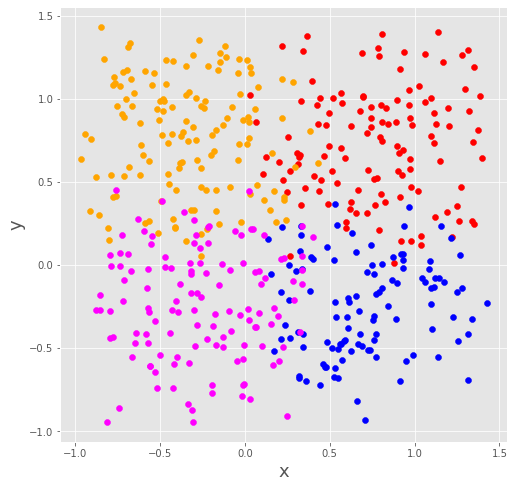

In [54]:
plt.figure(figsize=(8, 8))
plt.scatter(dataset_X_sqr[dataset_y_sqr == 0, 0], 
            dataset_X_sqr[dataset_y_sqr == 0, 1], color='r')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 1, 0], 
            dataset_X_sqr[dataset_y_sqr == 1, 1], color='b')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 2, 0], 
            dataset_X_sqr[dataset_y_sqr == 2, 1], color='orange')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 3, 0], 
            dataset_X_sqr[dataset_y_sqr == 3, 1], color='magenta')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

**Training models**

Now, use our newly generated toy training set to train a logisitic regression model and a decision tree.

To find the best performing decision tree model, search through the values in `option_grid` and train a model using each value for `max_leaf_nodes`. At the end of your grid search, print out the best `max_leaf_nodes` choice you found to identify the best-performing option:

In [57]:
option_grid = [2, 5, 10, 15, 20, 25, 30]

solvers = ['newton-cg', 'lbfgs']
multi_class = [ 'multinomial']


# GridSearchCV params
param_grid = dict(solver=solvers, multi_class=multi_class)
score = ['f1', 'accuracy']
grid = GridSearchCV(LogisticRegression(), param_grid, n_jobs=-1)

# Fitting Logistic Regression
grid.fit(dataset_X_sqr, dataset_y_sqr)
preds = grid.predict(dataset_X_sqr)
print(classification_report(dataset_y_sqr, preds))

print("Best Model: ",end = '')
print(grid.best_estimator_)
lr_model_name = str(grid.best_estimator_)
print(f"{grid.scorer_}: {grid.best_score_}")

regr_sqr = grid.best_estimator_
regr_sqr.fit(dataset_X_sqr, dataset_y_sqr)


              precision    recall  f1-score   support

           0       0.89      0.90      0.89       124
           1       0.87      0.88      0.88       111
           2       0.91      0.87      0.89       138
           3       0.86      0.88      0.87       127

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500

Best Model: LogisticRegression(multi_class='multinomial', solver='newton-cg')
<function _passthrough_scorer at 0x7ffa073e98c0>: 0.8799999999999999


LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [58]:
# Fitting Decision Tree 
param_grid = dict(max_leaf_nodes=option_grid)

grid = GridSearchCV( DecisionTreeClassifier(), param_grid, n_jobs=-1, refit=True)

grid.fit(dataset_X_sqr, dataset_y_sqr)
preds = grid.predict(dataset_X_sqr)
print(classification_report(dataset_y_sqr, preds))

print("Best Model: ",end = '')
print(grid.best_estimator_)
dt_model_name = str(grid.best_estimator_)
print(f"{grid.scorer_}: {grid.best_score_}")

regr_sqr_dt = grid.best_estimator_
regr_sqr_dt.fit(dataset_X_sqr, dataset_y_sqr)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       124
           1       0.92      0.91      0.91       111
           2       0.89      0.96      0.92       138
           3       0.96      0.86      0.91       127

    accuracy                           0.92       500
   macro avg       0.92      0.91      0.92       500
weighted avg       0.92      0.92      0.92       500

Best Model: DecisionTreeClassifier(max_leaf_nodes=10)
<function _passthrough_scorer at 0x7ffa073e98c0>: 0.8640000000000001


DecisionTreeClassifier(max_leaf_nodes=10)

**Performance metrics**

Many of the metrics we discussed above are specific to binary classification, since the concept of a true positive or true negative does not adapt well to large $K$. In this course, we will largely use classification accuracy as the primary metric. For advanced learners, read about area under the ROC curve (AUROC) for another popular metric for $K$-way classification.

Now, let's calculate the metrics for our best-performing decision tree models and then visualize their predictive results, as we did previously:

In [59]:
from sklearn.metrics import accuracy_score

pred_y_sqr = regr_sqr.predict(dataset_X_sqr)
dev_pred_y_sqr = regr_sqr.predict(dev_X_sqr)

pred_y_sqr_dt = regr_sqr_dt.predict(dataset_X_sqr)
dev_pred_y_sqr_dt = regr_sqr_dt.predict(dev_X_sqr)

print("[train] logreg | square dataset: acc: %.2f" % accuracy_score(dataset_y_sqr, pred_y_sqr))
print("[train] tree | square dataset: acc: %.2f" % accuracy_score(dataset_y_sqr, pred_y_sqr_dt))
print("[dev] logreg | square dataset: acc: %.2f" % accuracy_score(dev_y_sqr, dev_pred_y_sqr))
print("[dev] tree | square dataset: acc: %.2f" % accuracy_score(dev_y_sqr, dev_pred_y_sqr_dt))

[train] logreg | square dataset: acc: 0.88
[train] tree | square dataset: acc: 0.92
[dev] logreg | square dataset: acc: 0.88
[dev] tree | square dataset: acc: 0.90


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


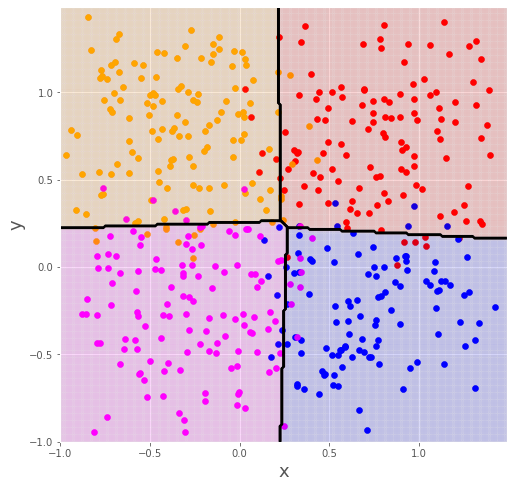

In [60]:
z, xx, yy = get_contour(regr_sqr, min_x=-1, max_x=1.5, min_y=-1, max_y=1.5)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_X_sqr[dataset_y_sqr == 0, 0], 
            dataset_X_sqr[dataset_y_sqr == 0, 1], color='r')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 1, 0], 
            dataset_X_sqr[dataset_y_sqr == 1, 1], color='b')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 2, 0], 
            dataset_X_sqr[dataset_y_sqr == 2, 1], color='orange')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 3, 0], 
            dataset_X_sqr[dataset_y_sqr == 3, 1], color='magenta')
plt.scatter(xx[z == 0], yy[z == 0], color='r', alpha=0.01)
plt.scatter(xx[z == 1], yy[z == 1], color='b', alpha=0.01)
plt.scatter(xx[z == 2], yy[z == 2], color='orange', alpha=0.01)
plt.scatter(xx[z == 3], yy[z == 3], color='magenta', alpha=0.01)
plt.contour(xx, yy, z, colors='k')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


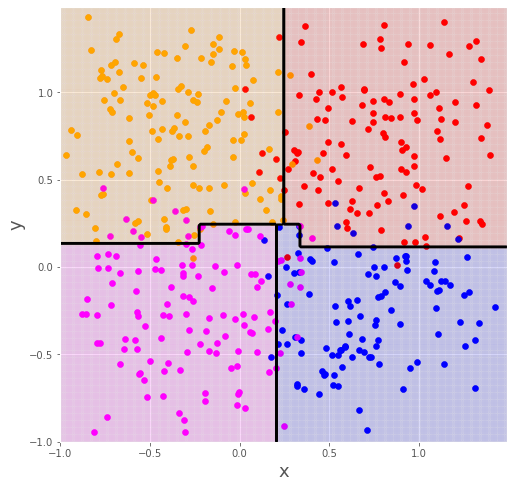

In [61]:
z, xx, yy = get_contour(regr_sqr_dt, min_x=-1, max_x=1.5, min_y=-1, max_y=1.5)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_X_sqr[dataset_y_sqr == 0, 0], 
            dataset_X_sqr[dataset_y_sqr == 0, 1], color='r')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 1, 0], 
            dataset_X_sqr[dataset_y_sqr == 1, 1], color='b')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 2, 0], 
            dataset_X_sqr[dataset_y_sqr == 2, 1], color='orange')
plt.scatter(dataset_X_sqr[dataset_y_sqr == 3, 0], 
            dataset_X_sqr[dataset_y_sqr == 3, 1], color='magenta')
plt.scatter(xx[z == 0], yy[z == 0], color='r', alpha=0.01)
plt.scatter(xx[z == 1], yy[z == 1], color='b', alpha=0.01)
plt.scatter(xx[z == 2], yy[z == 2], color='orange', alpha=0.01)
plt.scatter(xx[z == 3], yy[z == 3], color='magenta', alpha=0.01)
plt.contour(xx, yy, z, colors='k')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

# Conclusion and next steps

Great work! In this session, you got to try multiple models on three different datasets. We revisited the concepts of underfitting and overfitting, and we learned to use new evaluation metrics that are appropriate to classification, a common task in machine learning.

Next, we will work on classification problems in a higher dimensional setting. You can move on to part two of the notebook!